IMPORTING LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install googletrans==4.0.0-rc1
!pip install langdetect
!pip install pycountry

sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from googletrans import Translator
from langdetect import detect
import pycountry
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 43.6 MB/s eta 0:00:00


IMPORTING DATA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
file_path = "/content/drive/MyDrive/Genre Classification Dataset/train_data.txt"

# Load the data
train = pd.read_csv(file_path, sep=':::', names=['Title', 'Genre', 'Description']).reset_index(drop=True)

# Display the first few rows
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
file_path = "/content/drive/MyDrive/Genre Classification Dataset/test_data.txt"

# Load the data
test = pd.read_csv(file_path, sep=':::', names=['Title', 'Description']).reset_index(drop=True)

# Display the first few rows
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


DATA CLEANING

In [9]:
train.describe(include='object').T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [10]:
train.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [11]:
train.duplicated().sum() #No duplicates values

0

In [12]:
train.Genre.unique() #No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [13]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [14]:
test.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [15]:
test.duplicated().sum() #No duplicate values

0

Model Building

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using TfidfVectorizer to convert text data into TF-IDF vectors

# Lowercase characters for uniformity
tfidf_vectorizer = TfidfVectorizer(lowercase=True,

                                   # Considering only single words in each text (unigrams)
                                   ngram_range=(1, 1),

                                   # Removing common English stop words
                                   stop_words='english',

                                   # Ignore words that appear in less than 2 documents
                                   min_df=2)

# Transforming the training set descriptions into TF-IDF vectors
x_train = tfidf_vectorizer.fit_transform(train['Description'])

# Transforming the test set descriptions using the same TF-IDF vectorizer
x_test = tfidf_vectorizer.transform(test['Description'])


In [17]:
from imblearn.over_sampling import RandomOverSampler

# Since drama and documentary genres dominate the dataset, we'll address the imbalance using RandomOverSampler
# The accuracy before sampling is expected to be lower than the accuracy after oversampling

# Creating a RandomOverSampler instance
sampler = RandomOverSampler()

# Resampling the training data using the TF-IDF vectors and corresponding genre labels
# The resampled data (x_train_resampled) and labels (y_train_resampled) will have a balanced distribution of genres
x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, train['Genre'])


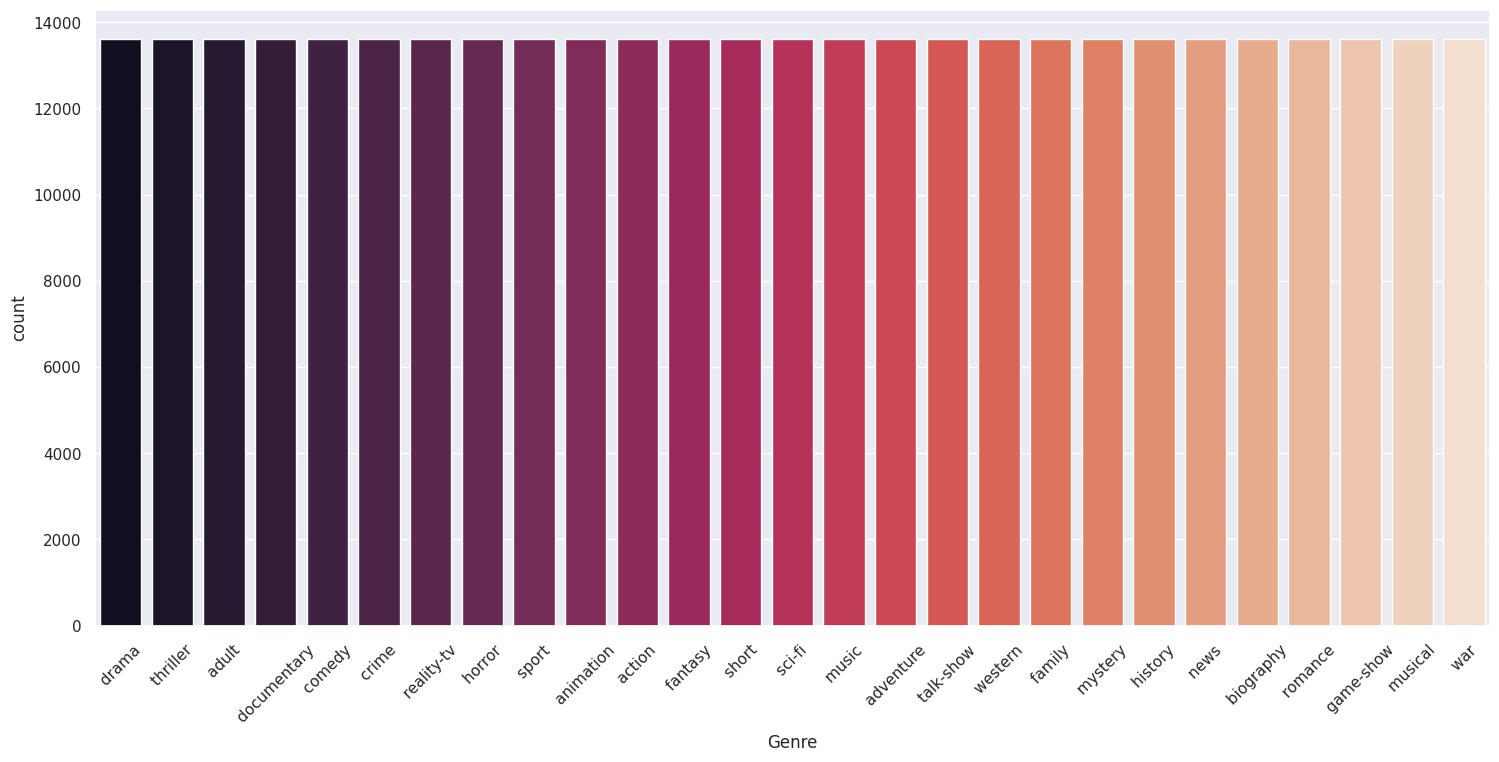

In [20]:
#Let's take a look at the genre distribution after oversampling
sns.countplot(x=y_train_resampled, palette='rocket')
plt.xticks(rotation=45)
plt.show()


In [21]:
#Double check for length of our data
print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [23]:
file_path = "/content/drive/MyDrive/Genre Classification Dataset/test_data_solution.txt"

y_actual = pd.read_csv(file_path, sep=':::', usecols=[2], header=None).rename(columns={2: 'Actual_Genre'})

y_actual.head()


,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [24]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5429889298892989
Running Time :  2.11 Secounds


In [25]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.36      0.48      0.41      1314
       adult        0.50      0.52      0.51       590
   adventure        0.31      0.25      0.28       775
   animation        0.31      0.22      0.26       498
   biography        0.04      0.03      0.03       264
      comedy        0.57      0.54      0.56      7446
       crime        0.16      0.17      0.17       505
 documentary        0.72      0.72      0.72     13096
       drama        0.64      0.56      0.60     13612
      family        0.25      0.22      0.24       783
     fantasy        0.15      0.12      0.13       322
   game-show        0.77      0.67      0.72       193
     history        0.09      0.06      0.07       243
      horror        0.52      0.68      0.59      2204
       music        0.39      0.73      0.50       731
     musical        0.19      0.10      0.13       276
     mystery        0.13      0.08      0.10       318
        n

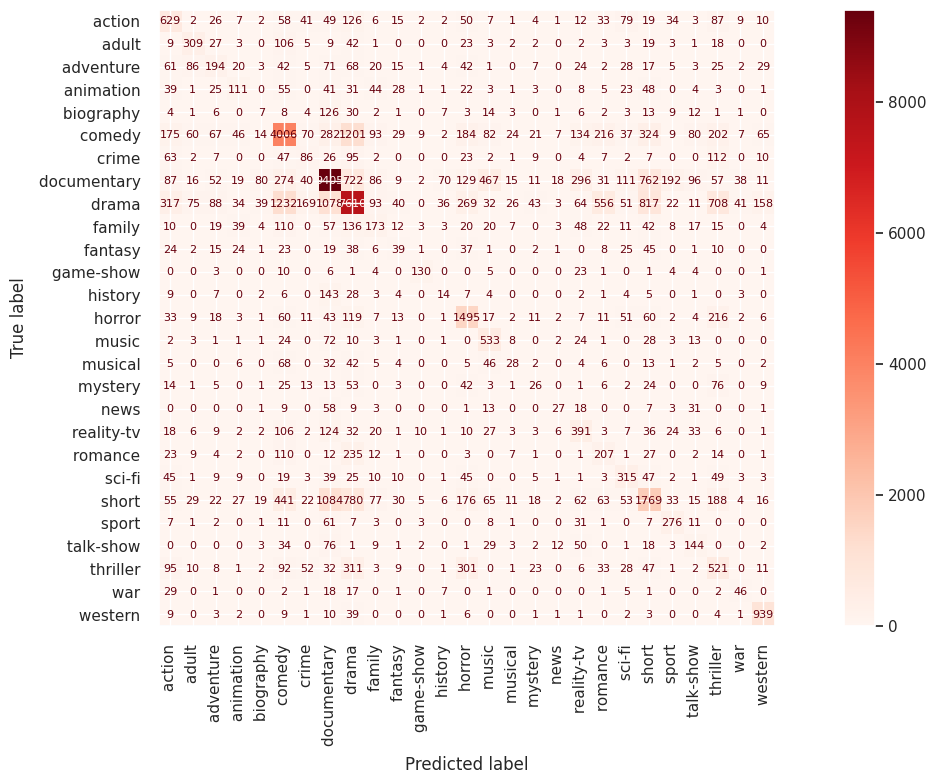

In [26]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [27]:
pd.concat([pd.concat([test,y_actual],axis=1),pd.Series(y_pred)],axis=1).rename(columns={0:'Predicted_Genre'}).head(10)

,Title,Description,Actual_Genre,Predicted_Genre
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller,short
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",comedy,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",drama,drama
4,Er nu zhai (1955),Before he was known internationally as a mart...,drama,drama
5,Riddle Room (2016),Emily Burns is being held captive in a room w...,horror,thriller
6,L'amica (1969),The beautiful but neglected wife of a brillia...,drama,drama
7,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,comedy,comedy
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,Press (2011),Press is a story of young people overwhelmed ...,drama,short


An alternative strategy to improve accuracy is to explore other methods or techniques.

In [28]:
# Experimenting with another approach to modify the target labels for enhanced accuracy

# Mapping genres to 'drama' or 'documentary' if they match, otherwise assigning 'other'
y_train_modified = train['Genre'].apply(lambda genre: genre if genre.strip() in ['drama', 'documentary'] else 'other')

# Modifying the actual genre labels in the test set similarly
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre: genre if genre.strip() in ['drama', 'documentary'] else 'other')

NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.6952583025830258
Running Time :  0.26 Secounds


CONCLUSION:

As anticipated, the model's accuracy improved, as it effectively discerns the genres of drama and documentary. For other genres, the model correctly categorizes them as 'other,' contributing to the overall enhancement in movie genre classification performance.